# Test divers

In [1]:
%matplotlib inline

import calendar
from calendar import isleap
import datetime
import os

import numpy as np
from scipy.stats import gaussian_kde

import IPython.display as IPdisplay, matplotlib.font_manager as fm
from PIL import Image
import glob

import xarray as xr
from netCDF4 import Dataset

import pandas as pd
from pandas import Series
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import Colormap as cm
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.path as mpath

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from eofs.standard import Eof

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_data='./data/'
dir_res='./result/'
dir_figs='./figs/'
dir_anim='./anim/'

if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)
if not os.path.exists(dir_anim):
    os.makedirs(dir_anim)
if not os.path.exists(dir_res):
    os.makedirs(dir_res)

In [3]:
infile = dir_data+'era5_z500_natl_daily_1950-2020.nc'
data0    = xr.open_dataset(infile)
data0

<xarray.Dataset>
Dimensions:  (time: 25933, lon: 240, lat: 121)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T18:00:00 ... 2020-12-31T18:00:00
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 85.5 87.0 88.5 90.0
Data variables:
    z        (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Nov 25 15:52:40 2021: ncrcat era5_z500_natl_daily_1950-...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 4.9.6 (Homepage = http://nco.sf.ne...

In [4]:
startday  = '1950-12-01T18'
endday  = '2020-03-31T18'
latS=20
latN=80
lonW=-80
lonE=30

# Date index from startday to endday
dates = pd.date_range(startday, endday, freq='D')

months=np.any([dates.month==12,dates.month==1,dates.month==2,dates.month==3],axis=0)
dates2=dates[months]


In [5]:
data = data0.assign_coords(lon=(((data0.lon + 180) % 360) - 180)).sortby('lon')
data_season = data.sel(lat=slice(latS,latN)).sel(time=dates2).sel(lon=slice(lonW,lonE))
data_season
lat  = data_season.lat.values
lon  = data_season.lon.values
time  = data_season.time.values

In [6]:
bounds = [lonW, lonE, latS, latN]
data_month    = data_season.sel(time=slice("2011-12-01","2011-12-31"))


zbis=data_month["z"]/9.81
levels1 = np.arange(4800,6200,100)
levels2 = np.arange(-500,550,50)
np.shape(zbis)

(31, 40, 74)

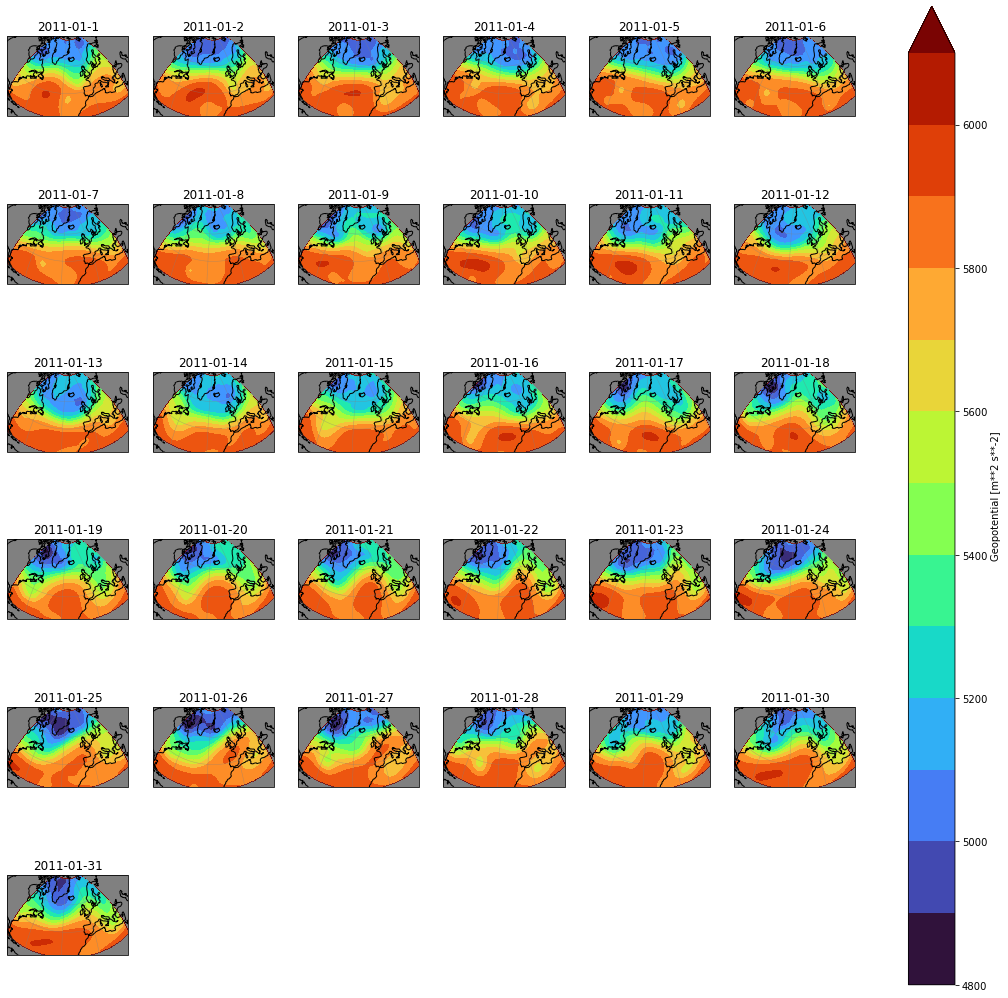

In [7]:
p=data_season.z.sel(time="2011-12").plot(cmap="turbo",col="time",col_wrap=6,subplot_kws=dict(projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2),facecolor="gray"), transform=ccrs.PlateCarree(),levels=levels1)
day=1


for i,ax in enumerate(p.axes.flat[:31]):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title("2011-01-"+str(day))
    ax.contourf(lon, lat, zbis[i,:,:], levels1, transform=ccrs.PlateCarree(), cmap="turbo", extend='both')
    day+=1
    

#plt.tight_layout()
plt.draw()

In [8]:
anomalies = data_season.groupby('time.dayofyear')-data_season.groupby('time.dayofyear').mean('time')

In [9]:
anomalies_month = anomalies.sel(time=slice("2011-12-01","2011-12-31"))
anobis=anomalies_month["z"]/9.81

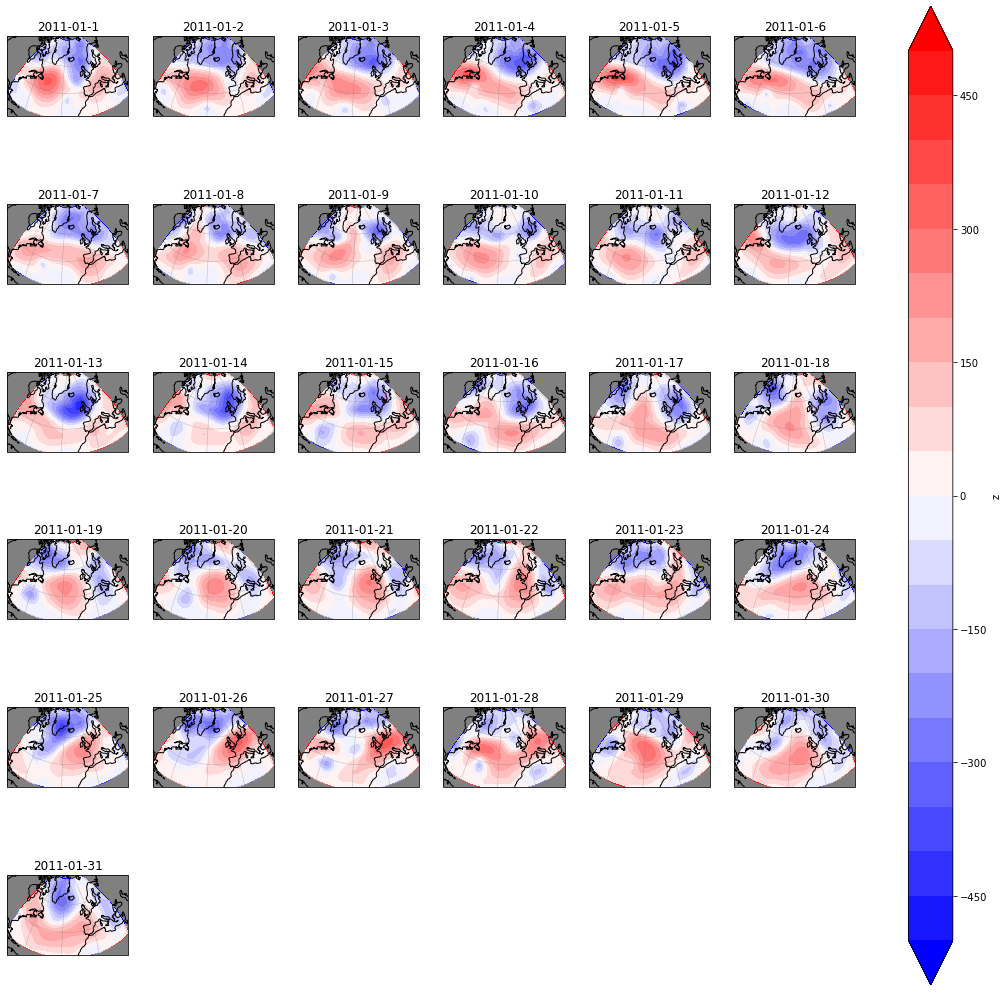

In [10]:
p=anomalies.z.sel(time="2011-12").plot(cmap="bwr",col="time",col_wrap=6,subplot_kws=dict(projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2),facecolor="gray"), transform=ccrs.PlateCarree(),levels=levels2)
day=1

for i,ax in enumerate(p.axes.flat[:31]):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title("2011-01-"+str(day))
    ax.contourf(lon, lat, anobis[i,:,:], levels2, transform=ccrs.PlateCarree(), cmap="bwr", extend='both')
    day+=1


In [11]:
infile1 = dir_res+"Z500"
data_season.to_netcdf(infile1)

infile2=dir_res+"anoZ500"
anomalies.to_netcdf(infile2)

In [12]:
filename = infile1
ncin = Dataset(filename, 'r')
lons = ncin.variables['lon'][:]
lats = ncin.variables['lat'][:]
Z500 = ncin.variables['z'][:]
ncin.close()

filename = infile2
ncin = Dataset(filename, 'r')
lons = ncin.variables['lon'][:]
lats = ncin.variables['lat'][:]
AnoZ500 = ncin.variables['z'][:]
ncin.close()

In [13]:
coslat = np.sqrt(np.cos(np.deg2rad(lat)))
wgts = np.reshape(coslat,(np.shape(coslat)[0],1))
solver = Eof(AnoZ500, weights=wgts, center=True)

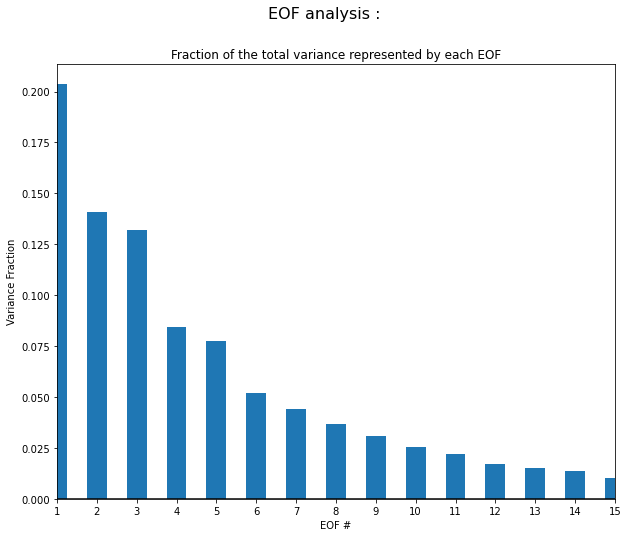

Variance expliquée par les 7 premières EOFs : 0.6899247046479311


In [14]:
varfrac = solver.varianceFraction()

fig = plt.figure(figsize=(10, 8))
fig.suptitle('EOF analysis : ', fontsize=16)

eof_num = range(1, 16)
plt.bar(eof_num, varfrac[0:15], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()
print("Variance expliquée par les 7 premières EOFs : " + str(sum(varfrac[0:6])))

In [15]:
n=10
eofs = solver.eofsAsCovariance(neofs=n)
pcs = solver.pcs(npcs=n, pcscaling=1)

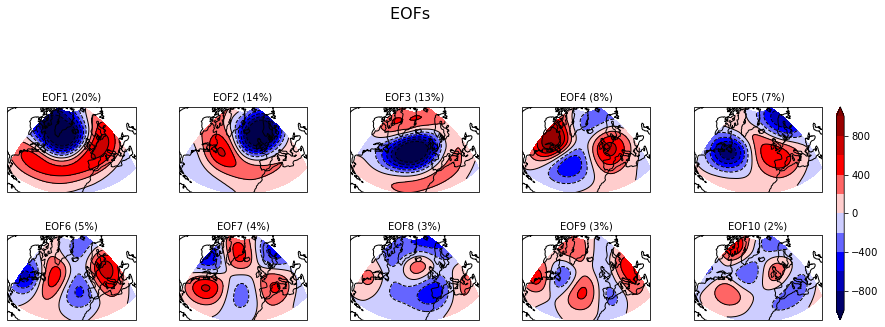

In [16]:
clevs = np.linspace(-1000, 1000, 11)


axes_class = (GeoAxes, dict(map_projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2)))
fig = plt.figure(figsize=(15,6))
fig.suptitle('EOFs ', fontsize=16)
axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, int(n/2)),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title('EOF'+str(i+1)+' ('+str(int(varfrac[i]*100))+'%)', fontsize=10, loc='center')
    cf = ax.contourf(lons, lats, eofs[i], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    c = ax.contour(lons, lats, eofs[i], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(cf)

plt.show()

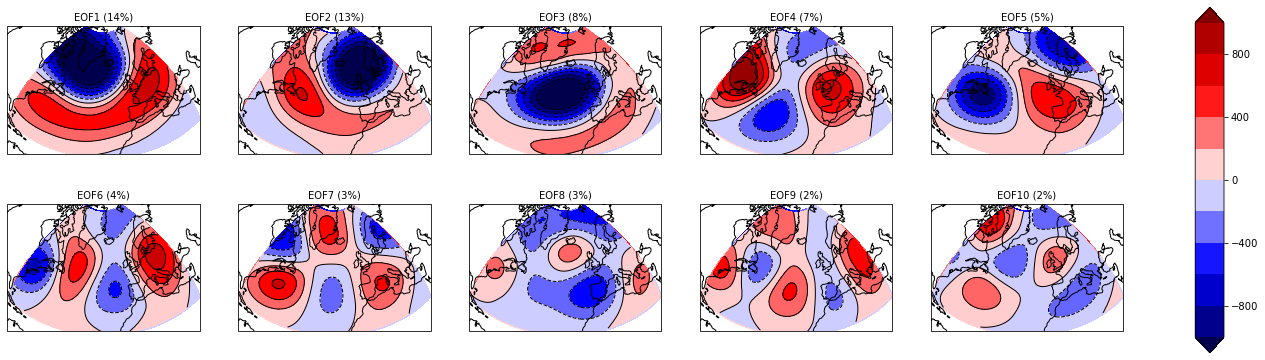

In [17]:
import matplotlib as mpl
clevs = np.linspace(-1000, 1000, 11)
cmap = mpl.cm.seismic
norm = BoundaryNorm(clevs, cmap.N, extend='both')
fig=plt.figure(figsize=(20,6))



for ieof in np.arange(1,11):
    ax=fig.add_subplot(2,5,ieof,projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2))
    p = ax.pcolormesh(lons,\
                   lats,\
                   eofs[0],\
                   vmin=-1000,\
                   vmax=1000, \
                   transform=ccrs.PlateCarree(),\
                   cmap="seismic",norm=norm )

    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title('EOF'+str(ieof)+' ('+str(int(varfrac[ieof]*100))+'%)', fontsize=10, loc='center')
    ax.contourf(lons, lats, eofs[ieof-1], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    ax.contour(lons, lats, eofs[ieof-1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cb_ax,extend='both')


In [18]:
eof1=eofs[0]
eof2=eofs[1]*(-1)
eof3=eofs[2]

pc1=pcs[:,0]
pc2=pcs[:,1]
pc3=pcs[:,2]


In [19]:
pcs = np.array([pc1,pc2,pc3,pcs[:,3],pcs[:,4],pcs[:,5],pcs[:,6],pcs[:,7],pcs[:,8],pcs[:,9]])
pcs=pcs.transpose()
# Number of clusters
kmeans = KMeans(n_clusters=4,n_init=100)
# Fitting the input data
kmeans = kmeans.fit(pcs)
# Getting the cluster labels
cluster = kmeans.predict(pcs)
# Centroid values
centroids = kmeans.cluster_centers_

print(cluster)
print(cluster.shape)
print(centroids.shape)

[0 0 2 ... 2 2 2]
(8488,)
(4, 10)


In [20]:
nc=[list(cluster[:]).count(i) for i in range(4)]
freq=[int(x/cluster.shape[0]*100) for x in nc]

In [21]:
colors=[""]*len(cluster)
couleur=["blue","red","green","orange","yellow","brown","black"]
for i in range(len(cluster)):
 colors[i]=couleur[cluster[i]]



In [22]:
id_cluster=[np.any([cluster==i],axis=0) for i in range(4)]

mean=[Z500[x,:,:].mean(axis=0)/9.81 for x in id_cluster]
anom=[AnoZ500[x,:,:].mean(axis=0)/9.81 for x in id_cluster]


IndexError: list index out of range

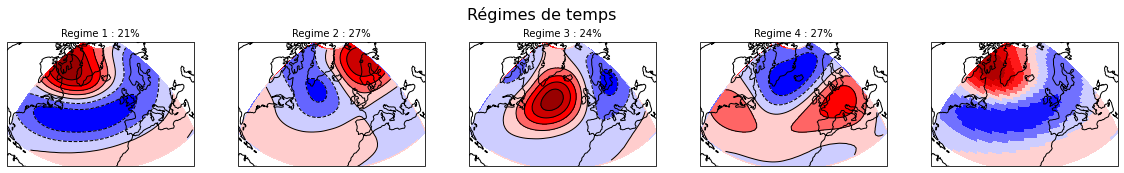

In [23]:
import matplotlib as mpl
clevs = np.linspace(-200, 200, 11)
cmap = mpl.cm.seismic
norm = BoundaryNorm(clevs, cmap.N, extend='both')
fig=plt.figure(figsize=(20,5))
fig.suptitle('Régimes de temps ', fontsize=16)

for ianom in np.arange(1,n+1):
    ax=fig.add_subplot(2,5,ianom,projection=ccrs.Orthographic(central_longitude=(lonW+lonE)/2, central_latitude=(latS+latN)/2))
    p = ax.pcolormesh(lons,\
                   lats,\
                   anom[0],\
                   vmin=-200,\
                   vmax=200, \
                   transform=ccrs.PlateCarree(),\
                   cmap="seismic",norm=norm )
    ax.coastlines()
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.set_title('Regime '+str(ianom)+' : '+str(freq[ianom-1])+'%', fontsize=10, loc='center', color=couleur[6])
    ax.contourf(lons, lats, anom[ianom-1], clevs, transform=ccrs.PlateCarree(), cmap="seismic", extend='both')
    ax.contour(lons, lats, anom[ianom-1], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())

cb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cb_ax,extend='both')